<h1>Predicting Elections with Pickup Trucks</h1>

a statistical mini-project demonstrating

<ul><strong>
<li>Least-Squares Linear Regression</li>
<li>Generalized Linear Models</li>
</strong></ul>

and, for people learning Python/SciPy/pandas:
<ul><strong>
<li>loading data from CSV files</li>
<li>aligning, sorting, and doing math on data in DataFrames</li>
<li>customizing scatter and bar plots</li>
</strong></ul>

<h3>Pseudocode:</h3>
<ol>
<li>Import 2008 US presidential election results for each state.
<li>Calculate pickup trucks per capita for each state.
<li>Plot these two variables and try to fit a curve to them.
<li>Use this curve to predict 2012 presidential election results.
<li>Compare the prediction to a null model.
</ol>

<h3>Raw data (2008):</h3>
<div><a href='http://www.fec.gov/pubrec/fe2008/federalelections2008.shtml
'>Federal Election Commission results by state</a></div>
<div><a href='http://www.census.gov/popest/data/historical/2000s/vintage_2008/state.html'>US Census Bureau population estimates by state</a></div>
<div><a href='http://www.fhwa.dot.gov/policyinformation/statistics/2008/mv9.cfm
'>US Dept. of Transportation truck and truck-tractor registrations</a></div>

<h3>Raw data (2012)</h3>
<div><a href='http://www.fec.gov/pubrec/fe2012/federalelections2012.shtml'>Federal Election Commission results by state</a></div>
<div><a href='http://www.census.gov/popest/data/state/totals/2012/index.html
'>US Census Bureau population estimates by state</a></div>
<div><a href='http://www.fhwa.dot.gov/policyinformation/statistics/2012/mv9.cfm
'>US Dept. of Transportation truck and truck-tractor registrations</a></div>

<hr>

designed and tested using <a href="https://store.continuum.io/cshop/anaconda/">Anaconda</a> 1.8.0, which includes <a href="https://www.python.org/">Python</a> 2.7.5 and <a href='http://pandas.pydata.org/'>pandas</a> 0.12.0.


In [3]:
%autosave 0

# Math & data imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Plotting imports
%matplotlib inline
from pylab import rcParams
rcParams['figure.figsize'] = 15, 5
redwhiteblue = plt.get_cmap('bwr')

Autosave disabled


<h2>Load 2008 data</h2>

I've already done some data pre-cleaning: get the raw data, delete some irrelevant parts, standardize spelling of state names, etc. Clean data is stored in a few CSV files. Load each file as a DataFrame, and display the first few rows to see if everything looks OK.

In [5]:
def get_csv(name):
    path = 'Data/' + name + '.csv'
    return pd.read_csv(path).set_index('State').astype(float)

ObamaMcCain = get_csv('ObamaMcCain')
Population = get_csv('Population2008')['7/1/2008']
Trucks = get_csv('Trucks2008')

print( 'Votes\n' + '-' * 50 )
print( ObamaMcCain.head() )
print( '\nTrucks\n' + '-' * 50 )
print( Trucks.head() )
print( '\nPeople\n' + '-' * 50 )
print( Population.head() )

Votes
--------------------------------------------------
         Obama   McCain  AllOthers     Total
State                                       
AL      813479  1266546      19794   2099819
AK      123594   193841       8762    326197
AZ     1034707  1230111      28657   2293475
AR      422310   638017      26290   1086617
CA     8274473  5011781     275646  13561900

Trucks
--------------------------------------------------
       Tractor   Farm   Pickup      Van      SUV  OtherLight
State                                                       
AL       97435  27827  1266930   261545   801407         NaN
AK        4289    553   205445    50485   165766        4040
AZ       28343   1300   875895   309599   835086        9110
AR       30154  40947   574398   125793   348440        4522
CA      132393    NaN  4029168  2397063  5359602       51836

People
--------------------------------------------------
State
AL     4661900
AK      686293
AZ     6500180
AR     2855390
CA    36756666
Na

Plot the relative popularity of Obama, McCain, and all others.

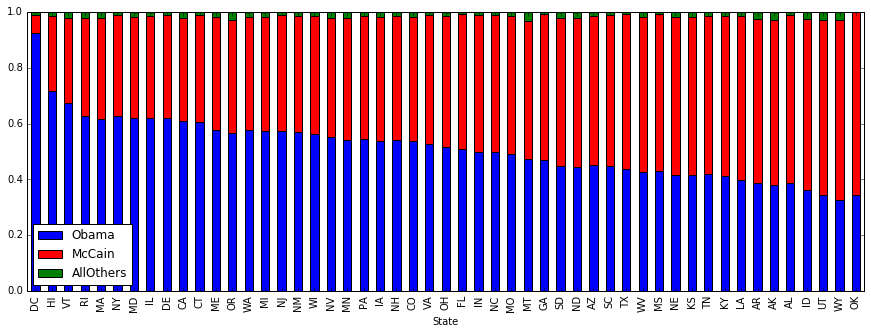

In [7]:
VotePct = ObamaMcCain.apply(lambda x: x / ObamaMcCain['Total'])
VotePct = VotePct[['Obama','McCain','AllOthers']]
VotePct.sort_values('McCain').plot(color=['b','r','g'],kind='bar',stacked='True',ylim=(0,1))

<h2>Plot the predictor and target variable</h2>

The (silly) idea is to use the popularity of pickup trucks in a state to predict Republican/Democratic popularity. Define a predictor and a target:
<ul>
<li><b>Truckness</b> = number of new pickup truck registrations in 2008 per capita
<li><b>RedPct</b> = fraction of <i>non-third-party</i> voters who voted Republican
</ul>

Align Truckness and RedPct in a DataFrame called <b>TruckVotes</b>. For plotting purposes, append Population and sort by Truckness. Check for missing or mis-aligned data, then scatterplot Truckness vs RedPct. Scale dots by population size, and color them by RedPct.

       Truckness    RedPct  Population
State                                 
DC      0.009281  0.065992      591833
NY      0.025856  0.364233    19490297
NJ      0.055607  0.421354     8682661
DE      0.057243  0.373619      873092
CO      0.057760  0.454492     4939456

0 of 51 rows are missing data


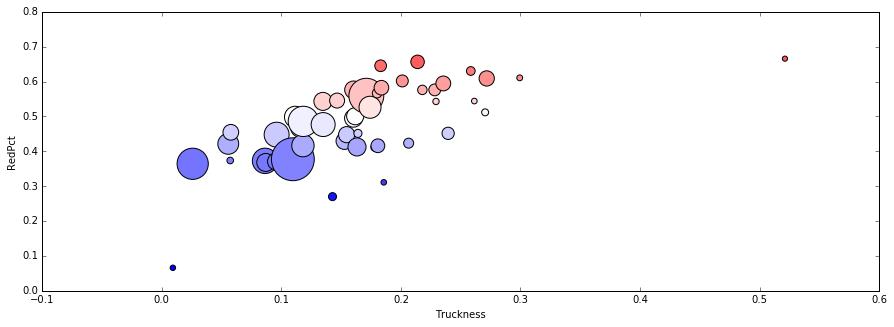

In [9]:
Truckness = Trucks['Pickup'] / Population
RedPct = VotePct['McCain'] / (VotePct['McCain'] + VotePct['Obama'])

TruckVotes = pd.concat([Truckness,RedPct,Population],axis=1,join='outer')
TruckVotes.columns = ['Truckness','RedPct','Population']
TruckVotes.sort_values('Truckness',inplace=True)
fBadRow = pd.isnull(TruckVotes).any(axis=1)
print( TruckVotes.head() )
print( "\n%s of %s rows are missing data" % (fBadRow.sum(),len(TruckVotes)) )

def redbluedots(df,xname,yname):
    x = df[xname]
    y = df[yname]
    c = df['RedPct']
    dot_size = df['Population'] / 2e4
    plt.scatter(x,y,c=c,s=dot_size,cmap=redwhiteblue,vmin=0.25,vmax=0.75)
    plt.xlabel(xname)
    plt.ylabel(yname)
    
redbluedots(TruckVotes,'Truckness','RedPct')

<h2>Linear regression</h2>

<b>Ordinary least-squares linear regression</b> assumes a linear$^1$ model:

$$
R_j = \alpha + \beta T_j + \epsilon_j
$$

where $R_j$ is RedPct of the $j$th sample, $T_j$ is its Truckness, $\alpha, \beta$ are two real constants to be determined, and the <b>error terms</b> $\{ \epsilon_j \}$ are random variables. Assume the errors $\epsilon_j$ are all independent, normally-distributed, have the same variance, and have mean 0. Under these (unrealistic) assumptions, the maximum-likelihood estimates of $\alpha$ and $\beta$ are whatever values minimize the total square error:

$$
\sum_{j=0}^{50} \epsilon^2 = \sum_{j=0}^{50} (R_j - \alpha - \beta T_j)^2
$$

Nearly all statistics packages include routines to calculate $\alpha$ and $\beta$. I used scipy.stats.linregress():

<small>1] To be precise, it's an <i>affine</i> model unless $\alpha=0$. But people usually call this model "linear" anyway.</small>

slope:		 0.8989
intercept:	 0.3313
r-squared:	 0.447
standard error:	 0.14


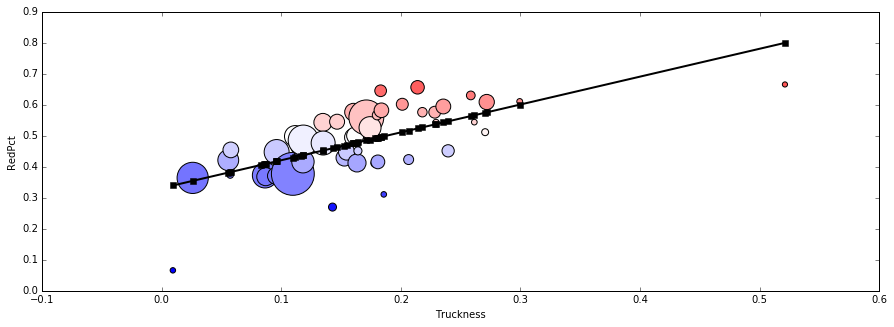

In [10]:
def linear_fit(df,xname,yname):
    x = df[xname]
    y = df[yname]
    slope, intercept, r, p, stderr = stats.linregress(x,y)
    predicted_y = slope * x + intercept
    print( "slope:\t\t", round(slope,4) )
    print( "intercept:\t", round(intercept,4) )
    print( "r-squared:\t", round(r*r,3) )
    print( "standard error:\t", round(stderr,2) )
    return predicted_y
TruckVotes['LinearFit'] = linear_fit(TruckVotes,'Truckness','RedPct')

redbluedots(TruckVotes,'Truckness','RedPct')
plt.plot(TruckVotes['Truckness'],TruckVotes['LinearFit'],'ks-',linewidth=2)

That $r^2$ value won't win ay awards, but it isn't terrible.  Calculate some other measures of error, and inspect the error term for each state:

Correct:	39 of 51 samples
Within 10%:	44 of 51 samples
RMS error:	 0.083
Typical error:	 0.049
Worst error:	 0.274
Bias:		 -0.0


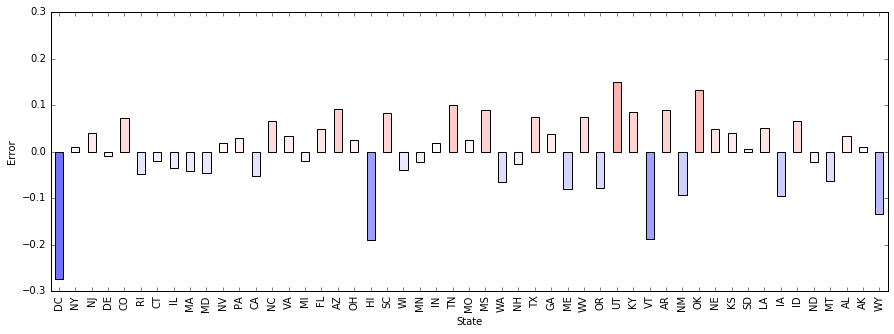

In [11]:
def show_error(predicted,actual):

    fTrueRed = (predicted > 0.5) & (actual > 0.5)
    fTrueBlue = (predicted < 0.5) & (actual < 0.5)
    fCorrect = fTrueRed | fTrueBlue
    fClose = (predicted - actual).abs() < 0.1
    
    err = actual - predicted
    rms = np.sqrt( (err*err).mean() )
    mad = err.abs().median()
    worst = err.abs().max()
    bias = err.mean()
    
    print( "Correct:\t%s of %s samples" % (fCorrect.sum(),len(actual)) )
    print( "Within 10%%:\t%s of %s samples" % (fClose.sum(),len(actual)) )
    print( "RMS error:\t", round(rms,3) )
    print( "Typical error:\t", round(mad,3) )
    print( "Worst error:\t", round(worst,3) )
    print( "Bias:\t\t", round(bias,3) )
    bar_colors = redwhiteblue(0.5+np.r_[err])
    err.plot(kind='bar',color=bar_colors)
    plt.ylabel('Error')
    plt.ylim((-0.3,0.3))
    
show_error(TruckVotes['LinearFit'],TruckVotes['RedPct'])

<h2>Linear regression in new coordinates</h2>

Linear models assume the predictor and target can be any real numbers. But in our case,
<ul>
<li>Truckness is always positive: $T \in [0,\infty)$
<li>RedPct is always a number between 0 and 1: $R \in [0,1]$
</ul>

For the $x$-axis, I want a smooth, monotonic transformation that maps $[0,\infty) \to (-\infty,\infty)$. I chose a logarithmic$^2$ transform:

<b>LogTruckness</b>
$\tau \equiv \log(T)$

For the $y$-axis, I want the inverse of a smooth sigmoid$^3$ function. The <b>logistic</b> function is a personal favorite which shows up in logistic regression and statistical physics (including my <a href='https://sites.google.com/site/samkennerly/maths'>dissertation</a>):

$$
\textrm{logistic}(x)
= \frac{e^x}{1+e^x}
= \frac{1}{1 + e^{-x}}
= \tfrac{1}{2} + \tfrac{1}{2}\tanh\left(\tfrac{1}{2}x\right)
$$

The inverse of the logistic function is the <b>logit</b> function:

$$
\textrm{logit}(x)
= \log \left(\frac{x}{1-x}\right)
= \log(x) - \log(1-x)
$$

Define a new $y$ coordinate to be the logit of RedPct:

<b>Redness</b> $\rho
\equiv \textrm{logit}(R)
= \log(R) - \log(1-R)$

I don't have a rigorous justification for either of these choices - they just have an appropriate domain and range. The plot below shows the result of least-squares linear regression in these new coordinates:

<small>
2] In NumPy, log() is the natural logarithm. Any other logarithm base would also work for our purposes.

3] A <b>sigmoid function</b> is bounded, differentiable, and monotonically increasing. By convention, the bounds are usually $[0,1]$.
</small>

slope:		 0.6516
intercept:	 1.1727
r-squared:	 0.61
standard error:	 0.07


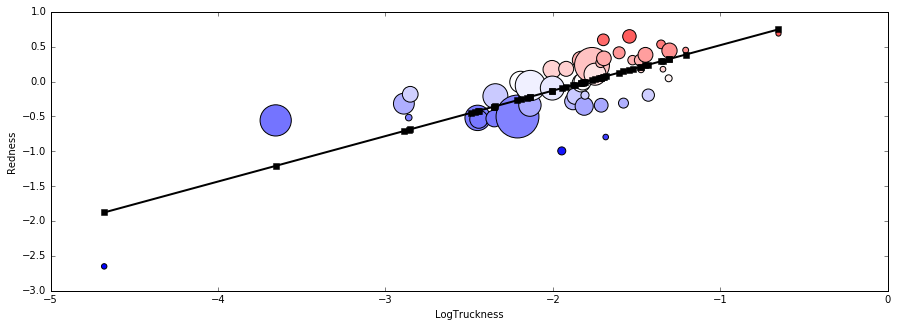

In [12]:
def logit(s): return np.log(s) - np.log(1-s)
TruckVotes['LogTruckness'] = np.log(TruckVotes['Truckness'])
TruckVotes['Redness'] = logit(TruckVotes['RedPct'])

predicted_redness = linear_fit(TruckVotes,'LogTruckness','Redness')

redbluedots(TruckVotes,'LogTruckness','Redness')
plt.plot(TruckVotes['LogTruckness'],predicted_redness,'ks-',linewidth=2)

That $r^2$ is a little more respectable. Transform the new prediction back to old coordinates:

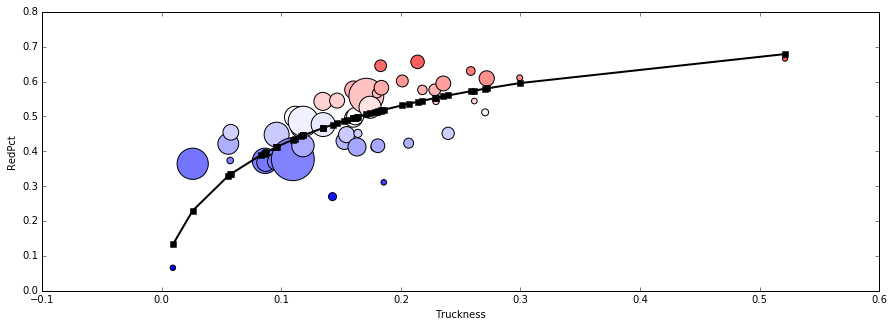

In [13]:
def logistic(s): return 1.0 / (1.0 + np.exp(-s))
TruckVotes['FancyFit'] = logistic(predicted_redness)
redbluedots(TruckVotes,'Truckness','RedPct')
plt.plot(TruckVotes['Truckness'],TruckVotes['FancyFit'],'ks-',linewidth=2)

<i>FancyFit</i> did a better job fitting the extreme values DC and WY, called 2 fewer states wrong, and had a better RMS error. (Its median error and "Within 10%" results were slightly worse, so it wasn't superior in every way.)

Correct:	41 of 51 samples
Within 10%:	42 of 51 samples
RMS error:	 0.075
Typical error:	 0.053
Worst error:	 0.208
Bias:		 0.002


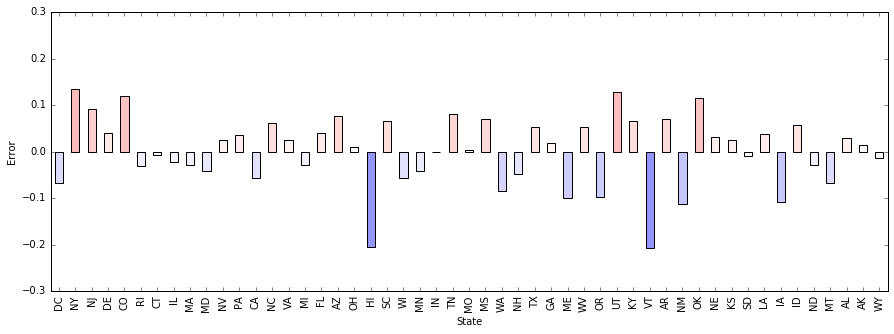

In [14]:
show_error(TruckVotes['FancyFit'],TruckVotes['RedPct'])

<i>FancyFit</i> is a simplified$^4$ <b>generalized linear model</b>. GLMs assume a transformed version of a linear model can predict the response variable. The idea is to choose an invertible <b>link function</b> g( ) and attempt to predict $g(y)$ instead of $y$ itself:

$$
E[y] = g^{-1}( \alpha + \beta x )
$$

Using LogTruckness as a predictor and logit as a link function, 

$$
\textrm{logit}\big(E[R]\big)
= \alpha + \beta \log(T)
$$

or equivalently, defining $\gamma \equiv e^{-\alpha}$,

$$
E[R]
= \textrm{logistic}\left( \alpha + \beta \log(T) \right)
= \frac{1}{1+\exp(-\alpha -\beta\log(T))}
= \frac{1}{1+\gamma T^{-\beta}}
= \frac{T^{\beta}}{T^{\beta} + \gamma}
$$

Given a positive Truckness as input, this model "knows" that expected RedPct is bounded. Check what happens in extreme cases:

$$
\lim_{T\to 0} E[R] = 0
\quad \textrm{and} \quad
\lim_{T\to \infty} E[R] = 1
$$

<small>
4] A full GLM would assume a probability distribution for the error terms and optimize $\alpha$ and $\beta$ accordingly. For simplicity and laziness, I just used least-squares.
</small>

<h2>Test the model on 2012 data</h2>

Load data from 2012, use the same values of $\alpha, \beta$, and see how well this model predicts the 2012  presidential election:

       Truckness    RedPct  Population
State                                 
DC      0.018843  0.074124      632323
NY      0.050760  0.356991    19570261
NJ      0.071052  0.410131     8864590
CT      0.077924  0.412274     3590347
MA      0.079811  0.382143     6646144
0 of 51 rows are missing data


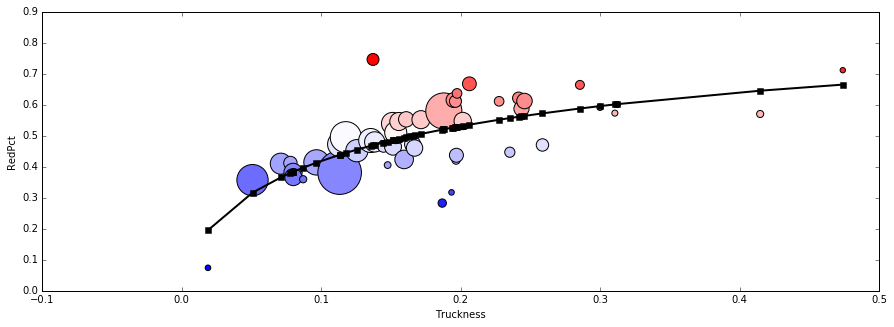

In [17]:
# Get 2012 data
ObamaRomney = get_csv('ObamaRomney')
Population2012 = get_csv('Population2012')['2012']
Trucks2012 = get_csv('Trucks2012')

# Calculate Truckness and RedPct
VotePct2012 = ObamaRomney.apply(lambda x: x / ObamaRomney['Total'])
VotePct2012 = VotePct2012[['Obama','Romney','AllOthers']]
RedPct2012 = VotePct2012['Romney'] / (VotePct2012['Romney'] + VotePct2012['Obama'])
Truckness2012 = Trucks2012['Pickup'] / Population2012

# Align, sort, and check for bad data
TruckVotes2012 = pd.concat([Truckness2012,RedPct2012,Population2012],axis=1,join='outer')
TruckVotes2012.columns = ['Truckness','RedPct','Population']
TruckVotes2012.sort_values('Truckness',inplace=True)
fBadRow = pd.isnull(TruckVotes2012).any(axis=1)
print( TruckVotes2012.head() )
print( "%s of %s rows are missing data" % (fBadRow.sum(),len(TruckVotes)) )

# Make a predictor function calibrated to 2008 results.
def predict_redness(truckness):
    x = np.log(truckness)
    y = 0.6516*x + 1.1727
    return logistic(y)

# Compare predicted results with actual 2012 results
TruckVotes2012['FancyFit'] = predict_redness(TruckVotes2012['Truckness'])
redbluedots(TruckVotes2012,'Truckness','RedPct')
plt.plot(TruckVotes2012['Truckness'],TruckVotes2012['FancyFit'],'ks-',linewidth=2)

Calculate overall error and errors for each state:

Correct:	38 of 51 samples
Within 10%:	42 of 51 samples
RMS error:	 0.083
Typical error:	 0.048
Worst error:	 0.277
Bias:		 0.004


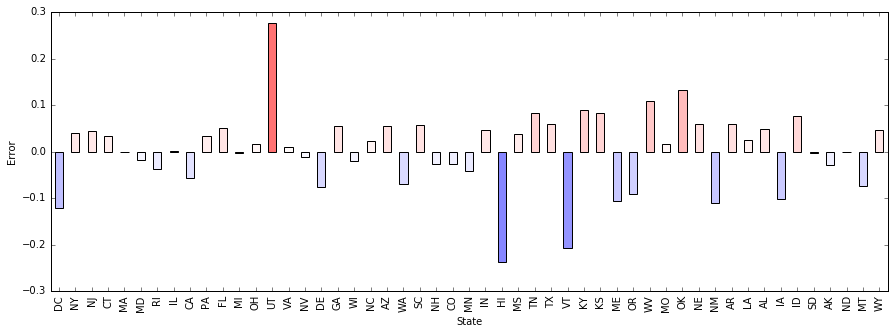

In [18]:
show_error(TruckVotes2012['FancyFit'],TruckVotes2012['RedPct'])

Compare with a <b>null model</b> which "predicts" 2012 results by assuming they will be exactly the same as 2008 results:

Correct:	49 of 51 samples
Within 10%:	50 of 51 samples
RMS error:	 0.032
Typical error:	 0.02
Worst error:	 0.101
Bias:		 0.022


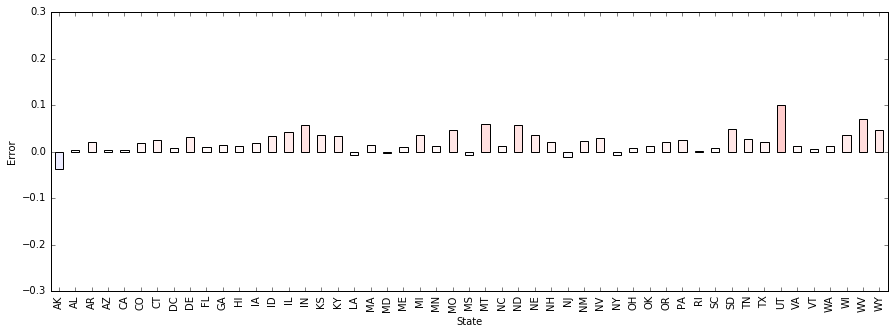

In [19]:
show_error(TruckVotes['RedPct'],TruckVotes2012['RedPct'])

<h2>Conclusions</h2>

<ol>
<li>There is a positive relationship between Truckness and Redness.</li>
<li>In testing, predicted RedPct was usually within 5% of the correct value, but...</li>
<li>The null model was a better predictor.</li>
</ol>

Truckness has some predictive value for presidential elections, but don't bet too much money on this crude model.

<h2>Wild speculations</h2>

It's tempting to make excuses for the model's worst errors: Utah and Hawaii. Romney would have been the first Mormon president, and Obama was the first president from Hawaii. I have no idea why Vermont is much bluer than its Truckness would suggest.

This model can't show whether pickup trucks cause people to vote Republican, nor whether voting Republican causes people to buy pickup trucks. I'd speculate that it's neither: pickup trucks are more practical in rural areas, and Republican national candidates tend to win rural areas and lose cities. It's also possible that Truckness and Redness are both indicators of <a href='http://www.economist.com/node/11581447'>the Big Sort</a>. 

<h2>"More research is indicated"</h2>

I'd like to see this mini-study replicated with finer sampling, e.g. at the county level.
